In [1]:
%load_ext autoreload
%autoreload 2
import torch.nn as nn
import pandas as pd
import torch
import numpy as np
import torchvision
import torch.optim as optim
from utils import ColorizeDataSet
from torchvision import transforms
import torch.utils.data as data
from dataset import train_loader, test_loader, ds_train

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(64),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(128),
    
    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
    nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(256),
    
    nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(512),
    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(512),
    
    # bottleneck, in future, fusion
    nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(256),
    
    # decoder
    nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(128),
    
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(64),
    
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(32),
    nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(16),
    
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(16, 2, kernel_size=3, padding=1), nn.Tanh()
)

In [4]:
def train(model, optimizer, criterion, epochs=10, lrs=None):
    val_loss, val_acc = [], []
    for e in range(epochs):
        print(f"epoch: {e}")
        running_loss = 0.0
        running_num = 0 
        if lrs is not None: lrs.step()
        for inputs, labels in train_loader:
            model.train()
            inputs, labels = inputs.to('cuda'), labels.to('cuda') 

            optimizer.zero_grad()
            logits = model(inputs)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.shape[0]
            running_num += inputs.shape[0]
        
        print(f"running loss: {running_loss/running_num}")
        vloss, vacc = get_validation_error(model)
        val_loss.append(vloss), val_acc.append(vacc)
    return pd.DataFrame({'loss': val_loss, 'acc': val_acc})

In [5]:
def get_validation_error(model):
    model.eval()
    loss = 0.0
    num = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            a_out = model(inputs)
        _, yh = torch.max(a_out, 1)
        loss += criterion(a_out, labels).item() * labels.shape[0]
        num += labels.shape[0]
    print(f"Validation Loss: {loss/num}")
    return loss/num, 0.0

In [5]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lrs = None # StepLR(optimizer, step_size=7, gamma=0.1)
criterion = torch.nn.MSELoss()
epochs = 5
stats_lr = train(model, optimizer, criterion, epochs, lrs)

epoch: 0
running loss: 0.03947391940772598
Validation Loss: 0.03718143224794443
epoch: 1
running loss: 0.036393693149392045
Validation Loss: 0.03629784624077776
epoch: 2
running loss: 0.03625773079086153
Validation Loss: 0.03595459339037208
epoch: 3
running loss: 0.035887329550766935
Validation Loss: 0.035522099185636494
epoch: 4
running loss: 0.03554599930770757
Validation Loss: 0.03624147679407132


In [74]:
checkpoint = torch.load('./best_so_far.pth')
model.cpu()
model.load_state_dict(checkpoint['state_dict'])


In [75]:
ds_test = ColorizeDataSet('/tmp/data/test',  transform=transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                           ]), normalize_lab=(
                                (50.0, 0.0, 0.0), (100.0, 255.0, 255.0)
                            ))
test_loader = data.DataLoader(ds_test,batch_size=32, shuffle=False)

In [76]:
x,y = next(iter(test_loader))

In [77]:
with torch.no_grad():
    model.eval()
    yhat = model(x)

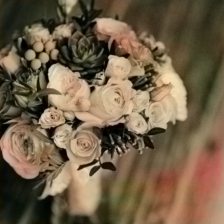

In [99]:
idx = 22
ds_train.normalized_lab_to_pil(x[idx,:], yhat[idx,:])

still very very sepia.... need to use mode IMO

In [53]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [54]:
params

6224114